In [1]:
import jax
import jax.numpy as jnp
from ripplegw.constants import gt, m_per_Mpc, PI, TWO_PI, MRSUN, C
from ripplegw.waveforms.IMRPhenomXAS_NRTidalv3 import gen_IMRPhenomXAS_NRTidalv3_hphc, gen_IMRPhenomXAS_NRTidalv3
from ripplegw import ms_to_Mc_eta, lambdas_to_lambda_tildes, get_eff_pads, get_match_arr

import lalsimulation as lalsim
import lal
import numpy as np

import matplotlib.pyplot as plt

/home/robinc/anaconda3/envs/jim_dev_env/lib/python3.12/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
# Frequency grid
T = 128
f_l = 20.0
f_sampling = 2 * 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

In [3]:
m1 = 1.37 # In solar masses
m2 = 1.37
chi1 = 0 #0.141 # Dimensionless spin
chi2 = 0 #0.141
lambda1 = 1001.8
lambda2 = 1001.8
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle

q = m1/m2
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
lambda_tilde, delta_lambda_tilde = lambdas_to_lambda_tildes(
    jnp.array([lambda1, lambda2, m1, m2])
)

theta_ripple = jnp.array(
    [
        Mc,
        eta,
        chi1,
        chi2,
        lambda_tilde,
        delta_lambda_tilde,
        dist_mpc,
        tc,
        phic,
        inclination,
    ]
)
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

In [4]:
from ripplegw.waveforms.NRTidalv3_utils import _get_merger_frequency, get_tidal_phase, get_NRTidalv3_coefficients, get_tidalphasePN_coeffs, get_tidal_phase_PN, general_planck_taper
from ripplegw.waveforms.IMRPhenomD_NRTidalv2 import get_planck_taper, get_tidal_amplitude, get_spin_phase_correction
from ripplegw.waveforms.IMRPhenomXAS import gen_IMRPhenomXAS_hphc
from ripplegw.waveforms.IMRPhenom_tidal_utils import get_kappa

In [5]:
theta_intrinsic = jnp.array([m1, m2, chi1, chi2, lambda1, lambda2])
M_s = m1 + m2
Xa = m1/M_s
f_merger_ripple = _get_merger_frequency(theta_intrinsic)
print(f_merger_ripple)

1595.8424


In [6]:
PN_coeffs = get_tidalphasePN_coeffs(theta_intrinsic)
NRTidalv3_coeffs = get_NRTidalv3_coefficients(theta_intrinsic, PN_coeffs)

M_omega = (PI * M_s *gt * fs_ripple)
A_P = general_planck_taper(fs, 1.15*f_merger_ripple, 1.35*f_merger_ripple)

kappa = get_kappa(jnp.array([m1,m2,chi1,chi2,lambda1,lambda2]))
tidal_amp = get_tidal_amplitude(M_omega**(2/3), theta_intrinsic, kappa, distance=dist_mpc)

tidal_phase = get_tidal_phase(M_omega, NRTidalv3_coeffs, PN_coeffs)
tidal_phasePN = get_tidal_phase_PN(M_omega, Xa, lambda1, lambda2, PN_coeffs)
tidal_phase_corr = tidal_phase * (1 - A_P) + tidal_phasePN * A_P

In [7]:
increasing = jnp.concatenate([jnp.array([False]), tidal_phase[1:] >= tidal_phase[:-1]])
fHzmrgcheck = 0.9*f_merger_ripple
# Apply fHz threshold
valid = (fs >= fHzmrgcheck) & increasing
print(valid)
first_valid = jnp.argmax(valid)  # returns 0 if none are True
print(first_valid)
found = jnp.any(valid)
print(found)
tidal_min_value = jnp.where(found, tidal_phase[first_valid - 1], 0.0)

# Build mask for indices after that point
mask = (jnp.arange(fs.size) > (first_valid - 1)) & found
print(mask)
phi_tidal = jnp.where(mask, tidal_min_value, tidal_phase)

[False False False ... False  True False]
215839
True
[False False False ...  True  True  True]


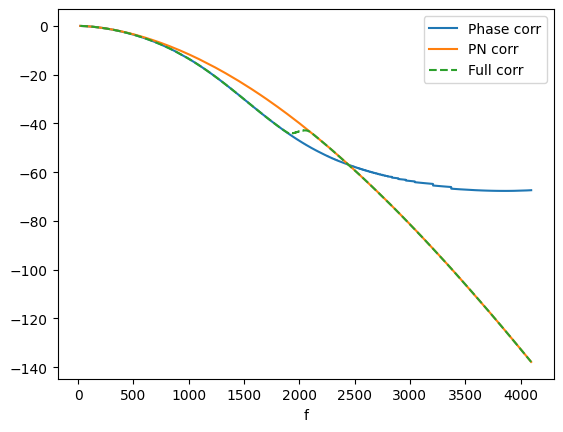

In [8]:
plt.plot(fs, tidal_phase,label='Phase corr')
plt.plot(fs, tidal_phasePN,label='PN corr')
plt.plot(fs, tidal_phase_corr, ls='--',label='Full corr')
plt.legend()
plt.xlabel('f')
# plt.xscale('log')
plt.show()

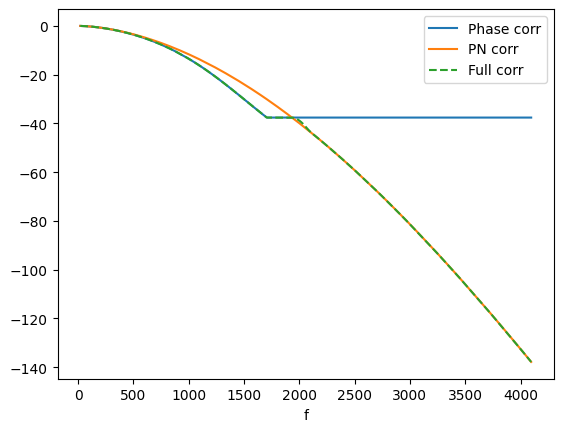

In [9]:
tidal_phase_corr_withMIN = phi_tidal * (1 - A_P) + tidal_phasePN * A_P
plt.plot(fs, phi_tidal,label='Phase corr')
plt.plot(fs, tidal_phasePN,label='PN corr')
plt.plot(fs, tidal_phase_corr_withMIN, ls='--',label='Full corr')
plt.legend()
plt.xlabel('f')
# plt.xscale('log')
plt.show()

In [10]:
laldict = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, lambda1)
lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, lambda2)
quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda1)
quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda2)
# print(quad1)
oct1 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad1)
oct2 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad2)
# print(oct1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict, quad1 - 1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict, quad2 - 1)

IMRphenom = "IMRPhenomXAS_NRTidalv3"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

theta = np.array(
    [m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination]
)

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

ph_tdLAL = np.zeros(fs.shape)
amp_tdLAL = np.zeros(fs.shape)
pl_taperLAL = np.zeros(fs.shape)

lalsim.SimNRTunedTidesFDTidalPhaseFrequencySeries(
    phi_tidal=ph_tdLAL,
    amp_tidal=amp_tdLAL,
    planck_taper=pl_taperLAL,
    fHz=fs,
    m1_SI=m1_kg,
    m2_SI=m2_kg,
    lambda1=lambda1,
    lambda2=lambda2,
    chi1=chi1,
    chi2=chi2,
    NRTidal_version=lalsim.NRTidalv3_V
)

0

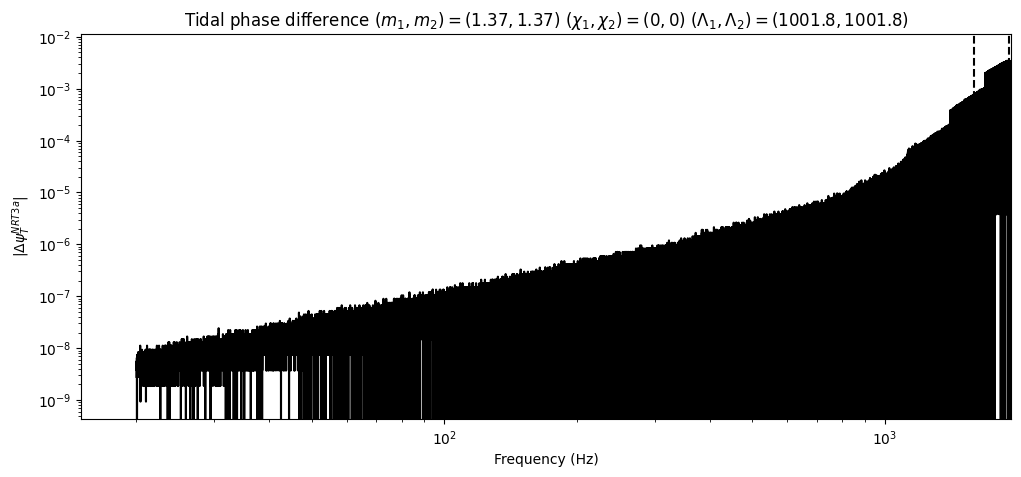

In [11]:
plt.figure(figsize=(12, 5))
delta_psi_tidal = ph_tdLAL - tidal_phase_corr
plt.plot(fs, abs(delta_psi_tidal), "-", color="black", label='')
plt.axvline(f_merger_ripple, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger_ripple, linestyle="--", color="black")
# plt.legend()
plt.title(
    r"Tidal phase difference ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$|\Delta \psi^{NRT3a}_T|$")
plt.xscale("log")
plt.xlim(f_l - 5, 1.2 * f_merger_ripple + 20)
plt.yscale("log")
plt.show()

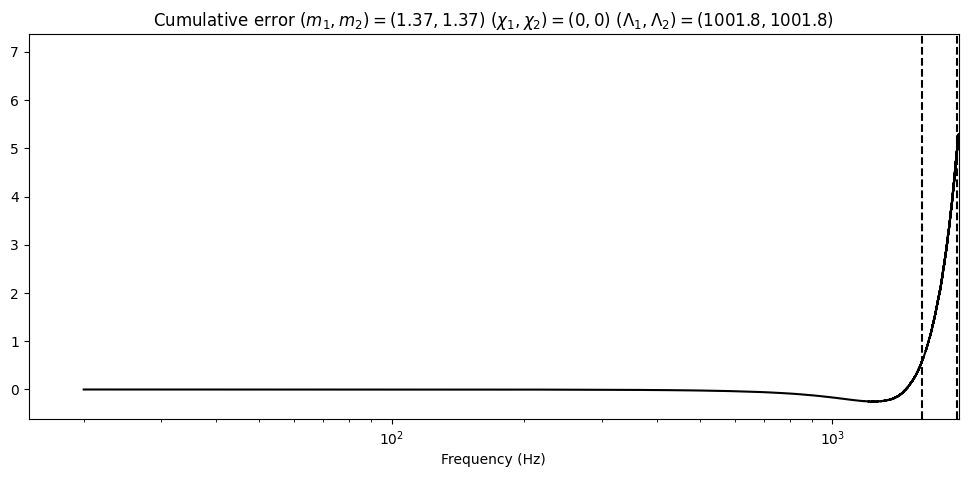

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(fs, jnp.cumsum(delta_psi_tidal), c='k')
plt.axvline(f_merger_ripple, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger_ripple, linestyle="--", color="black")
plt.title(
    r"Cumulative error ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.xlabel("Frequency (Hz)")
plt.xscale("log")
plt.xlim(f_l - 5, 1.2 * f_merger_ripple + 20)
# plt.yscale("log")
plt.show()

In [13]:
# And finally lets generate the waveform!
hp_ripple, hc_ripple = gen_IMRPhenomXAS_NRTidalv3_hphc(
    fs_ripple, theta_ripple, f_ref
)
hp_ripple

Array([ 5.4772518e-24-2.8787021e-24j,  1.0637312e-24+6.0926741e-24j,
       -6.1303162e-24-7.9777775e-25j, ...,  0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],      dtype=complex64)

In [14]:
hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)

approximantXAS = lalsim.SimInspiralGetApproximantFromString("IMRphenomXAS")
laldictXAS = lal.CreateDict()
hpXAS, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldictXAS,
    approximantXAS,
)

freqs_lal = np.arange(len(hp.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]
hpXAS_lalsuite = hpXAS.data.data[mask_lal]

In [15]:
f = freqs_lal[mask_lal]

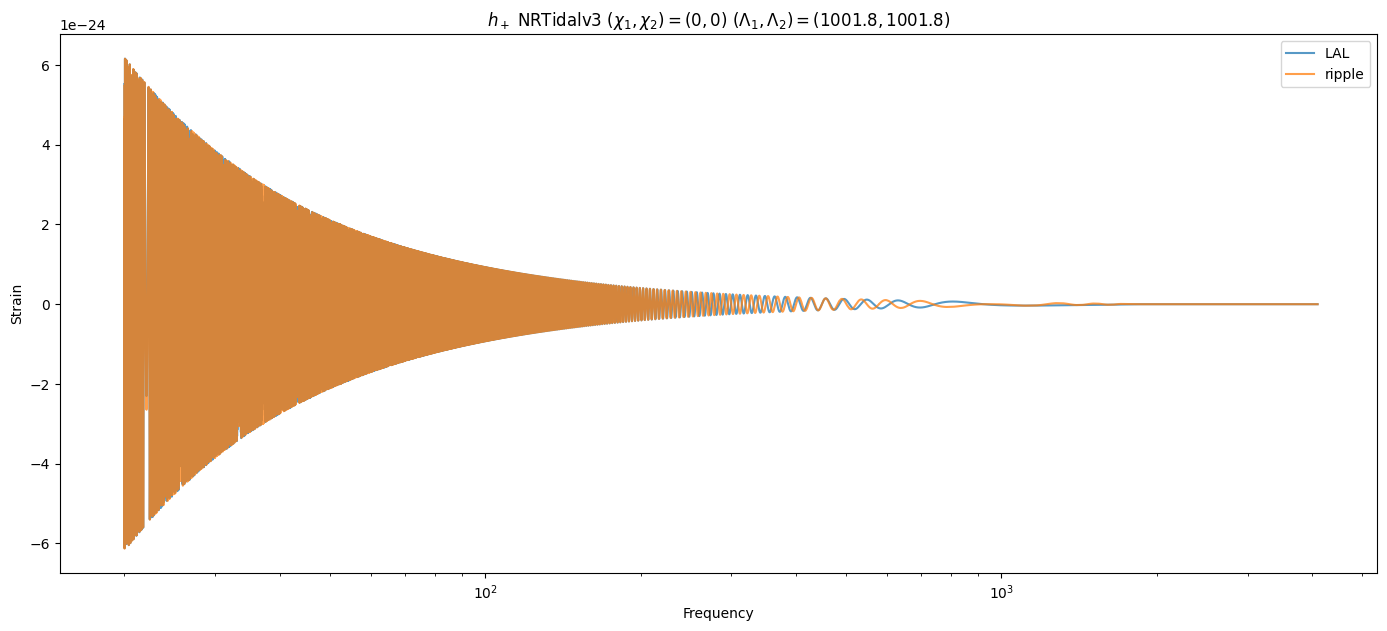

In [16]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label="LAL", alpha=a)
plt.plot(f, hp_ripple.real, "-", label="ripple", alpha=a)
# plt.plot(fs, hpXAS_lalsuite.real, label="LAL XAS", alpha=a)
plt.title(f"h+, NRTidalv3 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(
    r"$h_+$ NRTidalv3 ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(chi1,chi2,lambda1, lambda2)
)
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale("log")
plt.xlim(f_l - 5)
plt.legend()
plt.show()

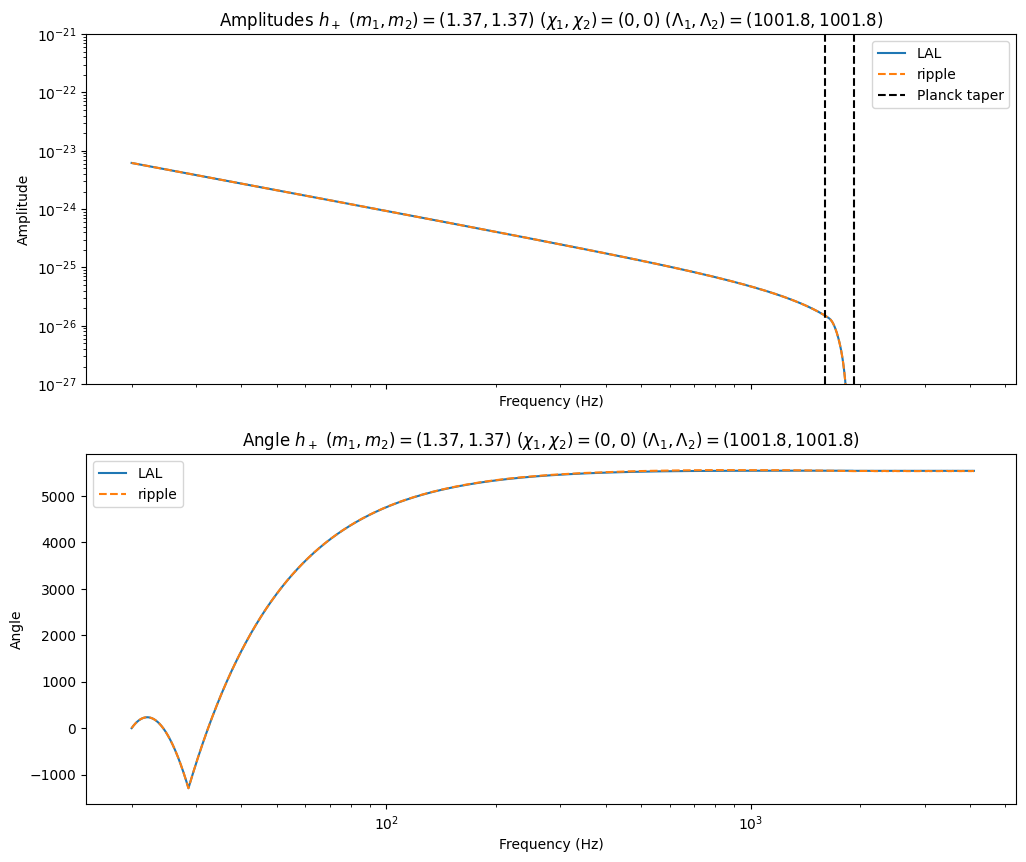

In [17]:
## Get the merger frequency to check the Planck taper window

l1, l2 = lambda1, lambda2
merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])

f_merger = f_merger_ripple
f_merger = float(f_merger)

## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label="LAL")
plt.plot(fs_ripple, A_ripple, "--", label="ripple")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger, linestyle="--", color="black")

plt.title(
    r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label="LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label="ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], phase_lalsuite, "-", label="LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label="ripple")
    name = "Phase"
plt.legend()
plt.title(
    r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        name, m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale("log")
plt.xlim(f_l - 5)
plt.show()

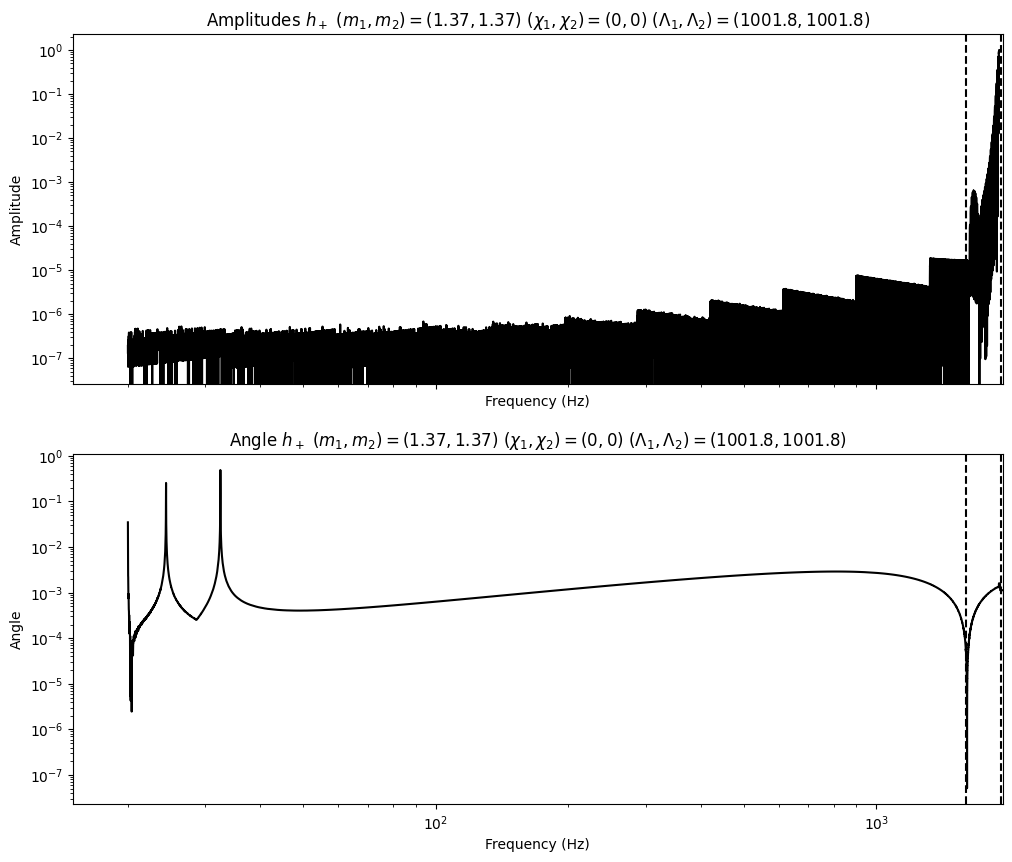

In [18]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple) / A_lalsuite
plt.plot(f, diffs_amplitude, "-", color="black")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger, linestyle="--", color="black")

plt.title(
    r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs((angle_lalsuite - angle_ripple)/angle_lalsuite), "-", color="black")
name = "Angle"
plt.axvline(f_merger, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger, linestyle="--", color="black")
# plt.legend()
plt.title(
    r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        name, m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale("log")
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.yscale("log")
plt.show()

In [19]:
A_lalsuiteXAS = jnp.abs(hpXAS_lalsuite)
angle_lalsuiteXAS = np.unwrap(np.angle(hpXAS_lalsuite))
phase_lalsuiteXAS = hpXAS_lalsuite / A_lalsuiteXAS

spin_corr_LAL = angle_lalsuite - angle_lalsuiteXAS
spin_corr_ripple = get_spin_phase_correction(M_omega**(2/3), theta_intrinsic)

/home/robinc/anaconda3/envs/jim_dev_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


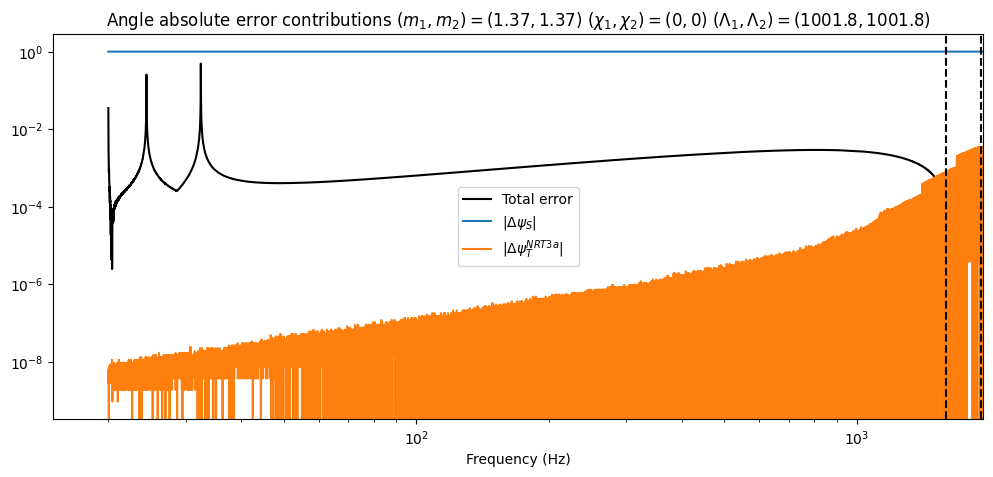

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(f, abs((angle_lalsuite - angle_ripple)/angle_lalsuite), "-", color="black", label='Total error')
plt.plot(f, abs((spin_corr_LAL - spin_corr_ripple)/spin_corr_LAL), label=r"$|\Delta \psi_S|$")
plt.plot(fs, abs(delta_psi_tidal), "-", label=r"$|\Delta \psi^{NRT3a}_T|$")
plt.legend()
plt.title(
    r"Angle absolute error contributions ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.yscale('log')
plt.axvline(f_merger, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger, linestyle="--", color="black")
plt.xlabel("Frequency (Hz)")
plt.xscale("log")
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.show()

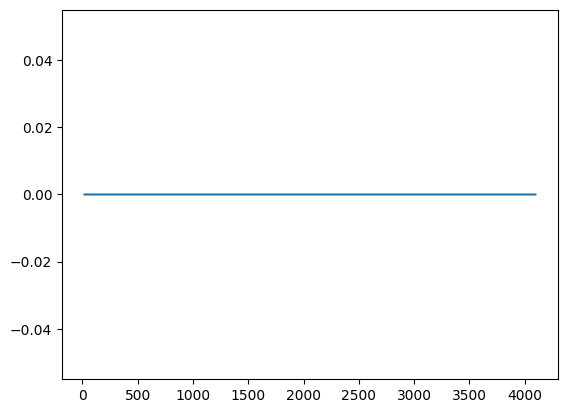

In [21]:
plt.plot(f, spin_corr_ripple)